# import libraries

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import itertools  
import math
import itertools
from sklearn.model_selection import train_test_split

import keras
from keras.layers import Dense, Input, Dropout, Flatten
from keras.layers import LSTM, Embedding, Bidirectional
from keras.models import Model
from keras.initializers import Constant
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.callbacks import History 
from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn import metrics
from keras.regularizers import l2
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report 

import tensorflow as tf

Using TensorFlow backend.


## reading data to be trained

In [2]:
# reading data from csv files

path = r'C:\Users\91901\Code Here\CQA\dataset\Subtask C'

train_base = pd.read_csv(os.path.join(path,'TRAIN-BASE.csv'))
test_base = pd.read_csv(os.path.join(path,'TEST-BASE.csv'))
val_base = pd.read_csv(os.path.join(path,'VAL-BASE.csv'))

def read_df(df):
    f = df['feature'].tolist()
    x = df['question'].tolist()
    xx = df['answer'].tolist()
    y = df['labels'].tolist()
    return f, x, xx, y

f_train, x_train, xx_train, y_train = read_df(train_base)
f_test, x_test, xx_test, y_test = read_df(test_base)
f_val, x_val, xx_val, y_val = read_df(val_base)

# PRINT AND CHECK TRAINING, TESTING AND VALIDATION SET

print('\nTraining: ', len(f_train), len(x_train), len(xx_train), len(y_train)) #must be same
print('\nTesting: ', len(f_test), len(x_test), len(xx_test), len(y_test))
print('\nValidation: ', len(f_val), len(x_val), len(xx_val), len(y_val))


Training:  19990 19990 19990 19990

Testing:  7000 7000 7000 7000

Validation:  5000 5000 5000 5000


In [3]:
y_test[:5] #checking

['PotentiallyUseful', 'Bad', 'Good', 'Good', 'Bad']

# let's read and make embeddings for data

In [4]:
avg_feature_length = 10
avg_question_length = 20
avg_answer_length = 50
MAX_SEQUENCE_LENGTH = FINAL_SEQUENCE_LENGTH = 100

In [5]:
# FOR GLOVE VECTORS

def read_glove_vecs(GLOVE_DIR, EMBEDDING_DIM):
    
    with open(os.path.join(GLOVE_DIR, 'glove.6B.'+ str(EMBEDDING_DIM)+'d.txt'),  encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map


def pretrained_embedding_layer(word_to_vec_map, word_to_index, random_term):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map[random_term].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. 
    # Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

# GLOVE_DIR = 'glove.6B'
# GLOVE_DIR = r'C:\Users\NoBotsHere\codehere\CQACodes\qa_dataset\glove.6B'
GLOVE_DIR = r'C:\Users\91901\Code Here\CQA\dataset\glove.6B'

EMBEDDING_DIM = 50
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs(GLOVE_DIR, EMBEDDING_DIM)
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index, "massage")

In [6]:
def generate_data_for_keras( t1, t2, t3, Y, 
                            word_index):

    t1_sequences = [] #first vector 
    t2_sequences = [] #second vector
    t3_sequences = [] #three vector

    for t1_keys in t1:
        t1_sequences.append([word_index[i] if i in word_index.keys() else 0 for i in t1_keys.lower().split()])
    
    for t2_keys in t2:
        t2_sequences.append([word_index[i] if i in word_index.keys() else 0 for i in t2_keys.lower().split()])
    
    for t3_keys in t3:
        t3_sequences.append([word_index[i] if i in word_index.keys() else 0 for i in t3_keys.lower().split()])
           
    # padding 
    # long sentences truncated to maxlen (last sequences are kept)
    # short sentences padded with 0 (pad are added at begining)
    t1_data = pad_sequences(t1_sequences, maxlen= avg_feature_length, padding='post')  
    t2_data = pad_sequences(t2_sequences, maxlen= avg_question_length, padding='post') 
    t3_data = pad_sequences(t3_sequences, maxlen= avg_answer_length, padding='post') 

    print('\nShape of question text data tensor:', t2_data.shape)
    print('\nShape of answer text data tensor:', t3_data.shape)
    print('\nShape of feature text data tensor:', t1_data.shape)
 
    
    y = []
    
    for t in Y:    
        if t =='Bad':
            y.append(0)
        elif t =='Good':
            y.append(2)
        elif t == 'PotentiallyUseful':
            y.append(1)
    
       
    label = np.array(y)
    print('\nShape of label data tensor:', label.shape)
    print('\nlabel data:', label)
    
    return t1_data, t2_data, t3_data, label


# # data for keras layers
#T1 IS FIRST TEXT FEATURE TEXT
#T2 IS QUESTION TEXT 
#T3 IS ANSWER TEXT
print('\nTraining: ') 
t1_train, t2_train, t3_train, y_train  = generate_data_for_keras(f_train, x_train, xx_train, y_train, word_to_index)

print('\nTesting: ')
t1_test, t2_test, t3_test, y_test  = generate_data_for_keras(f_test, x_test, xx_test, y_test, word_to_index)

print('\nValidation: ')
t1_val, t2_val, t3_val, y_val  = generate_data_for_keras(f_val, x_val, xx_val, y_val, word_to_index)


print('\nTraining: ', len(t1_train), len(t2_train), len(t3_train), len(y_train)) #must be same
print('\nTesting: ', len(t1_test), len(t2_test), len(t3_test), len(y_test))
print('\nValidation: ', len(t1_val), len(t2_val), len(t3_val), len(y_val))


Training: 

Shape of question text data tensor: (19990, 20)

Shape of answer text data tensor: (19990, 50)

Shape of feature text data tensor: (19990, 10)

Shape of label data tensor: (19990,)

label data: [2 0 2 ... 0 0 0]

Testing: 

Shape of question text data tensor: (7000, 20)

Shape of answer text data tensor: (7000, 50)

Shape of feature text data tensor: (7000, 10)

Shape of label data tensor: (7000,)

label data: [1 0 2 ... 0 0 0]

Validation: 

Shape of question text data tensor: (5000, 20)

Shape of answer text data tensor: (5000, 50)

Shape of feature text data tensor: (5000, 10)

Shape of label data tensor: (5000,)

label data: [2 2 1 ... 0 0 0]

Training:  19990 19990 19990 19990

Testing:  7000 7000 7000 7000

Validation:  5000 5000 5000 5000


In [7]:
# DISPLAY training, testing and validation data 

print('------- Training Data -------\n')
for i in range (2):
    print ('Entry:', t1_train[i] , '\n', t2_train[i] , '\n', t3_train[i] , '\nLabel:' , y_train[i], '\n')
      
print('------- Testing Data -------\n')
for i in range (2):
    print ('Entry:', t1_test[i] , '\n', t2_test[i] , '\n', t3_test[i] , '\nLabel:' , y_test[i], '\n')

print('------- Validation Data -------\n')
for i in range (2):
    print ('Entry:', t1_val[i] , '\n', t2_val[i] , '\n', t3_val[i] , '\nLabel:' , y_val[i], '\n')

------- Training Data -------

Entry: [236086 268641      0      0      0      0      0      0      0      0] 
 [386432 185457  90548  87972 164328 268641 151349      0      0      0
      0      0      0      0      0      0      0      0      0      0] 
 [     0 193716 192973 308561  72057      0 188481 357266 257168      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0] 
Label: 2 

Entry: [236086 268641      0      0      0      0      0      0      0      0] 
 [386432 185457  90548  87972 164328 268641 151349      0      0      0
      0      0      0      0      0      0      0      0      0      0] 
 [386321 357266 256046 268046 357266      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0

# Parameters for Training

In [8]:
# define parameters 

nn_units = 128
dropout_inputs = 0.2
recurrent_dropout_inputs = 0.15
batchsize = 64
epochs_count = 100

# Preparing Contextualized Embeddings

In [9]:
%%time

# Prepare embeddings sequences by initializing keras embedding layer with glove embedding values

sequence_input_feat = Input(shape=(avg_feature_length,), dtype='int32', name='featureLayer')
embedded_feat_sequences = embedding_layer(sequence_input_feat)
      
sequence_input_ques = Input(shape=(avg_question_length,), dtype='int32', name='questionLayer')
embedded_ques_sequences = embedding_layer(sequence_input_ques)


sequence_input_ans = Input(shape=(avg_answer_length,), dtype='int32', name='answerLayer')
embedded_ans_sequences = embedding_layer(sequence_input_ans)

Wall time: 42.9 ms


In [10]:
%%time

def bilstm_embeddings(embedded_sequences):

   
    n = Bidirectional(LSTM(nn_units, return_sequences= True, 
                            name = 'bilstm_layer', dropout = dropout_inputs, 
                            recurrent_dropout = recurrent_dropout_inputs))(embedded_sequences)

    return n

# call for embeddings

n1 = bilstm_embeddings(embedded_feat_sequences)
n2 = bilstm_embeddings(embedded_ques_sequences)
n3 = bilstm_embeddings(embedded_ans_sequences)

print(n1)
print(n2)
print(n3)

Tensor("bidirectional_1/concat:0", shape=(None, 10, 256), dtype=float32)
Tensor("bidirectional_2/concat:0", shape=(None, 20, 256), dtype=float32)
Tensor("bidirectional_3/concat:0", shape=(None, 50, 256), dtype=float32)
Wall time: 1.87 s


# Model definition for Classification


In [11]:
# default helpful

INPUT_SEQUENCES = [sequence_input_feat, sequence_input_ques, sequence_input_ans]
TRAIN_FIT = [t1_train, t2_train, t3_train]
VAL_FIT = [t1_val, t2_val, t3_val]
TEST_FIT = [t1_test, t2_test, t3_test]

In [12]:
# defining model

def classification_model(INPUT_EMBEDDINGS, INPUT_SEQUENCES):
    
    # FOR MODEL_1 
    
    FinalLayer = keras.layers.concatenate(inputs = INPUT_EMBEDDINGS, axis = 1)
    FinalLayer = keras.layers.GlobalAveragePooling1D()(FinalLayer)
    predictions = Dense(3, activation = "softmax")(FinalLayer)

    # MODEL_1 FOR ANSWER SELECTION

    model = Model(inputs = INPUT_SEQUENCES , outputs = predictions)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
    
    model.summary()

    return model

# Common functions - Plot, Evaluate, Save Results

# Training Model

In [13]:
def training_model(model, MODEL_NAME, TRAIN_FIT, VAL_FIT):
    

    callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 5)
    
    checkpoint_path = os.path.join(MODEL_NAME + '_checkpoint.h5')

    modelcheck_acc = ModelCheckpoint(checkpoint_path, 
                                     monitor='acc', mode='max', 
                                    save_best_only = True, verbose=1)

    CALLBACK = [callback, modelcheck_acc]

    history = model.fit(TRAIN_FIT, y_train, 
                            batch_size = batchsize, 
                            epochs = epochs_count, 
                            validation_data = (VAL_FIT, y_val), #replace to t1_val ...so on.
                            callbacks = CALLBACK
                           )
    return history

In [14]:
# into files save
  
# model_directory = "Resulting Model"
# MODEL_SAVING_DIR = os.path.join(path, model_directory)
# os.mkdir(MODEL_SAVING_DIR) 
 
# MODEL_SAVING_DIR = (r'\folder-path')

def save_models(model, MODEL_NAME):
  
    # serialize model to JSON
    model_json = model.to_json()
    with open(MODEL_NAME + ".json", "w") as json_file:
        json_file.write(model_json)

    # serialize weights to HDF5
    model.save_weights(MODEL_NAME + ".h5")
    print("\nTHIS MODEL HAS BEEN SAVED TO DIRECTORY: ", os.getcwd())

In [15]:
def plot_graphs(history, string):
    print('training of model')
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

In [16]:
def plot_both_graphs(history):
    # plot train and validation loss
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    # plot train and validation loss
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model train vs validation acc')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    

In [17]:
def evaluate_model(model, TEST_FIT):
    # Returns the loss value & metrics values for the model in test mode.
    print("Evaluated on metrics ", model.metrics_names)

    score_loss, score_acc = model.evaluate(TEST_FIT, y_test, batch_size=batchsize)
    print("Test Loss :", score_loss, "Test Accuracy: ", score_acc)

    # MODEL_1 FOR PREDICTIONS 
    model_predictions = model.predict(TEST_FIT)
    print("\npredictions shape is: ", model_predictions.shape)
#     print("\nand few predictions are:\n", model_predictions[:3], "\n\n while original test labels look like: ", y_test[:10])

    #To find the predicted class for each test example, you need to use axis=1
    predicted_class_names = np.argmax(model_predictions, axis = 1)
    print("\n\n Predictions into Class Labels:", predicted_class_names)

    print("\n\n METRICS CLASSIFICATION REPORT IS:\n", classification_report (y_test, np.argmax(model_predictions, axis = 1)))
    
    return model_predictions, predicted_class_names

In [18]:
def result_store(predicted_class_names):
    
    df = pd.DataFrame(columns = ['feature', 'text_1', 'text_2', 'true_label'])
    df['feature'] = f_test
    df['text_1'] = x_test
    df['text_2'] = xx_test
    df['true_label'] = y_test
    df['predicted_label'] = predicted_class_names

    return df

In [19]:
## put into files these 


# df_true_labels = pd.DataFrame(y_test, columns = ['y_test_labels'])
# df_true_labels.y_test_labels.value_counts()
# df_true_labels.head()

# df_pred_labels = pd.DataFrame(predicted_class_names_1, columns = ['y_pred_labels'])
# df_pred_labels.y_pred_labels.value_counts()
# df_pred_labels.head()

# print("no of true labels:\n", df_true_labels.y_test_labels.value_counts())
# print("no of predicted labels:\n", df_pred_labels.y_pred_labels.value_counts())

In [20]:
%%time

# call for stacked embeddings

def stacked_bilstm_embeddings(layer):
    
    for i in range(4):
#         print('run:', i, '--', 'layer-name:', layer)
        layer = Bidirectional(LSTM(nn_units, return_sequences= True, name = 'bilstm_layer', 
                        dropout=dropout_inputs, recurrent_dropout = recurrent_dropout_inputs))(layer)
    
    return layer

Wall time: 0 ns


## Model_bilstm for Classification

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
featureLayer (InputLayer)       (None, 10)           0                                            
__________________________________________________________________________________________________
questionLayer (InputLayer)      (None, 20)           0                                            
__________________________________________________________________________________________________
answerLayer (InputLayer)        (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             20000050    featureLayer[0][0]               
                                                                 questionLayer[0][0]        

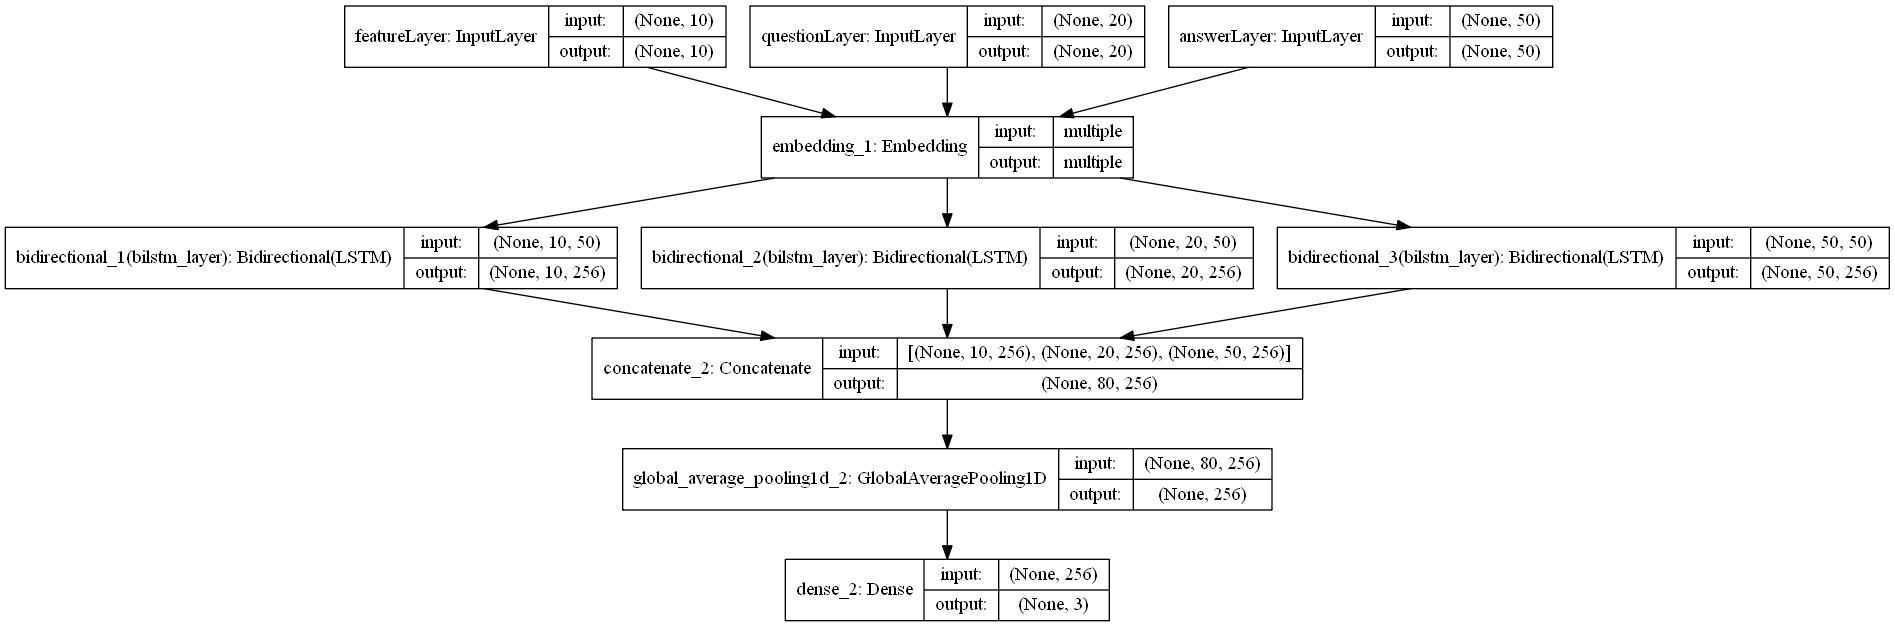

In [21]:
#CUSTOM COLUMNS

INPUT_EMBEDDINGS = [n1, n2, n3]

model_bilstm = classification_model(INPUT_EMBEDDINGS, INPUT_SEQUENCES)
plot_model(model_bilstm, to_file = 'model_bilstm.png', show_shapes=True, show_layer_names=True)

In [22]:
history_bilstm = training_model(model_bilstm, 'model-bilstm', TRAIN_FIT, VAL_FIT) 
save_models(model_bilstm, 'model-bilstm')

Train on 19990 samples, validate on 5000 samples
Epoch 1/100
19990/19990 [==============================] - 31s 2ms/step - loss: 0.5743 - acc: 0.8154 - val_loss: 0.5850 - val_acc: 0.8122

Epoch 00001: acc improved from -inf to 0.81536, saving model to model-bilstm_checkpoint.h5
Epoch 2/100
19990/19990 [==============================] - 27s 1ms/step - loss: 0.5352 - acc: 0.8209 - val_loss: 0.5634 - val_acc: 0.8130

Epoch 00002: acc improved from 0.81536 to 0.82086, saving model to model-bilstm_checkpoint.h5
Epoch 3/100
19990/19990 [==============================] - 27s 1ms/step - loss: 0.5209 - acc: 0.8220 - val_loss: 0.5975 - val_acc: 0.8120

Epoch 00003: acc improved from 0.82086 to 0.82201, saving model to model-bilstm_checkpoint.h5
Epoch 4/100
19990/19990 [==============================] - 29s 1ms/step - loss: 0.5078 - acc: 0.8224 - val_loss: 0.5774 - val_acc: 0.8124

Epoch 00004: acc improved from 0.82201 to 0.82241, saving model to model-bilstm_checkpoint.h5
Epoch 5/100
19990/1999

19990/19990 [==============================] - 27s 1ms/step - loss: 0.3788 - acc: 0.8587 - val_loss: 0.6469 - val_acc: 0.7938

Epoch 00037: acc did not improve from 0.86013
Epoch 38/100
19990/19990 [==============================] - 27s 1ms/step - loss: 0.3746 - acc: 0.8628 - val_loss: 0.7034 - val_acc: 0.7984

Epoch 00038: acc improved from 0.86013 to 0.86278, saving model to model-bilstm_checkpoint.h5
Epoch 39/100
19990/19990 [==============================] - 27s 1ms/step - loss: 0.3672 - acc: 0.8644 - val_loss: 0.6444 - val_acc: 0.7890

Epoch 00039: acc improved from 0.86278 to 0.86438, saving model to model-bilstm_checkpoint.h5
Epoch 40/100
19990/19990 [==============================] - 27s 1ms/step - loss: 0.3657 - acc: 0.8649 - val_loss: 0.6629 - val_acc: 0.7982

Epoch 00040: acc improved from 0.86438 to 0.86488, saving model to model-bilstm_checkpoint.h5
Epoch 41/100
19990/19990 [==============================] - 27s 1ms/step - loss: 0.3617 - acc: 0.8671 - val_loss: 0.6439 - va

training of model


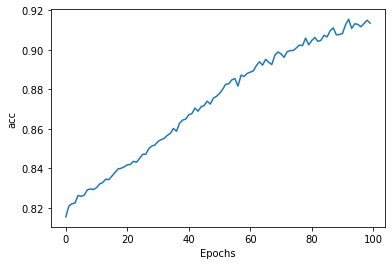

training of model


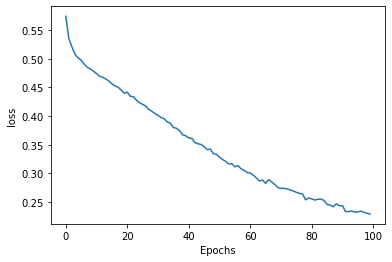

In [23]:
plot_graphs(history_bilstm, 'acc')
plot_graphs(history_bilstm, 'loss')

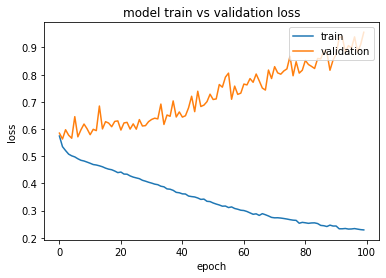

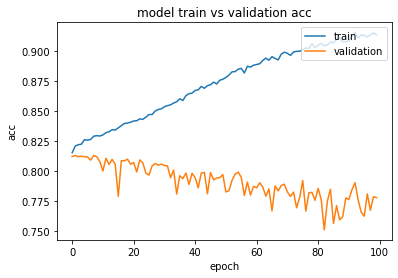

In [24]:
plot_both_graphs(history_bilstm)

In [25]:
# temp if program halts and stops abruptly

# from keras.models import model_from_json

# model_temp = 'model-bilstm.h5'
# model_bilstm = model_temp

# # load json and create model
# json_file = open('model-bilstm.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model-bilstm.h5")
# print("Loaded model from disk")


# # evaluate loaded model on test data
# loaded_model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
# model_bilstm = loaded_model

In [26]:
model_predictions_bilstm, predicted_class_names_bilstm = evaluate_model(model_bilstm, TEST_FIT)

Evaluated on metrics  ['loss', 'acc']
7000/7000 [==============================] - 2s 245us/step
Test Loss : 0.8634687491336039 Test Accuracy:  0.8102856874465942

predictions shape is:  (7000, 3)


 Predictions into Class Labels: [0 0 0 ... 0 0 0]


 METRICS CLASSIFICATION REPORT IS:
               precision    recall  f1-score   support

           0       0.86      0.93      0.90      5943
           1       0.12      0.06      0.08       403
           2       0.26      0.15      0.19       654

    accuracy                           0.81      7000
   macro avg       0.41      0.38      0.39      7000
weighted avg       0.76      0.81      0.78      7000



In [27]:
result_bilstm = result_store(predicted_class_names_bilstm)

print("no of true labels:\n", result_bilstm.true_label.value_counts())
print("no of predicted labels:\n", result_bilstm.predicted_label.value_counts())

result_bilstm.head()

no of true labels:
 0    5943
2     654
1     403
Name: true_label, dtype: int64
no of predicted labels:
 0    6422
2     385
1     193
Name: predicted_label, dtype: int64


,feature,text_1,text_2,true_label,predicted_label
0,"""IT Jobs in Qatar","""""how hard is it for you to get a decent payin...",Are you Qatari? That may be the answer.,1,0
1,"""IT Jobs in Qatar","""""how hard is it for you to get a decent payin...",No I am not qatari; but I can speak Arabic; It...,0,0
2,"""IT Jobs in Qatar","""""how hard is it for you to get a decent payin...",Not easy..... unless you have a father's rp or...,2,0
3,"""IT Jobs in Qatar","""""how hard is it for you to get a decent payin...",Wasta my child...thats all it takes. Having Am...,2,0
4,"""IT Jobs in Qatar","""""how hard is it for you to get a decent payin...",also as tahsinmim said..helps sometimes to han...,0,0


In [28]:
results_path = os.getcwd()
result_bilstm.to_csv(os.path.join(results_path,'FQA-BILSTM-CLASSIFIED.csv'), index_label = False, index = False)

# Stacked Model

In [29]:
# define parameters for stacked

nn_units = 64
dropout_inputs = 0.3
recurrent_dropout_inputs = 0.2
batchsize = 32
epochs_count = 80

# call for embeddings

n1 = bilstm_embeddings(embedded_feat_sequences)
n2 = bilstm_embeddings(embedded_ques_sequences)
n3 = bilstm_embeddings(embedded_ans_sequences)

print(n1)
print(n2)
print(n3)

Tensor("bidirectional_4/concat:0", shape=(None, 10, 128), dtype=float32)
Tensor("bidirectional_5/concat:0", shape=(None, 20, 128), dtype=float32)
Tensor("bidirectional_6/concat:0", shape=(None, 50, 128), dtype=float32)


In [30]:
stacked_n1 = stacked_bilstm_embeddings(n1)
stacked_n2 = stacked_bilstm_embeddings(n2)
stacked_n3 = stacked_bilstm_embeddings(n3)

print(stacked_n1)
print(stacked_n2)
print(stacked_n3)

Tensor("bidirectional_10/concat:0", shape=(None, 10, 128), dtype=float32)
Tensor("bidirectional_14/concat:0", shape=(None, 20, 128), dtype=float32)
Tensor("bidirectional_18/concat:0", shape=(None, 50, 128), dtype=float32)
Wall time: 5.25 s


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
featureLayer (InputLayer)       (None, 10)           0                                            
__________________________________________________________________________________________________
questionLayer (InputLayer)      (None, 20)           0                                            
__________________________________________________________________________________________________
answerLayer (InputLayer)        (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             20000050    featureLayer[0][0]               
                                                                 questionLayer[0][0]        

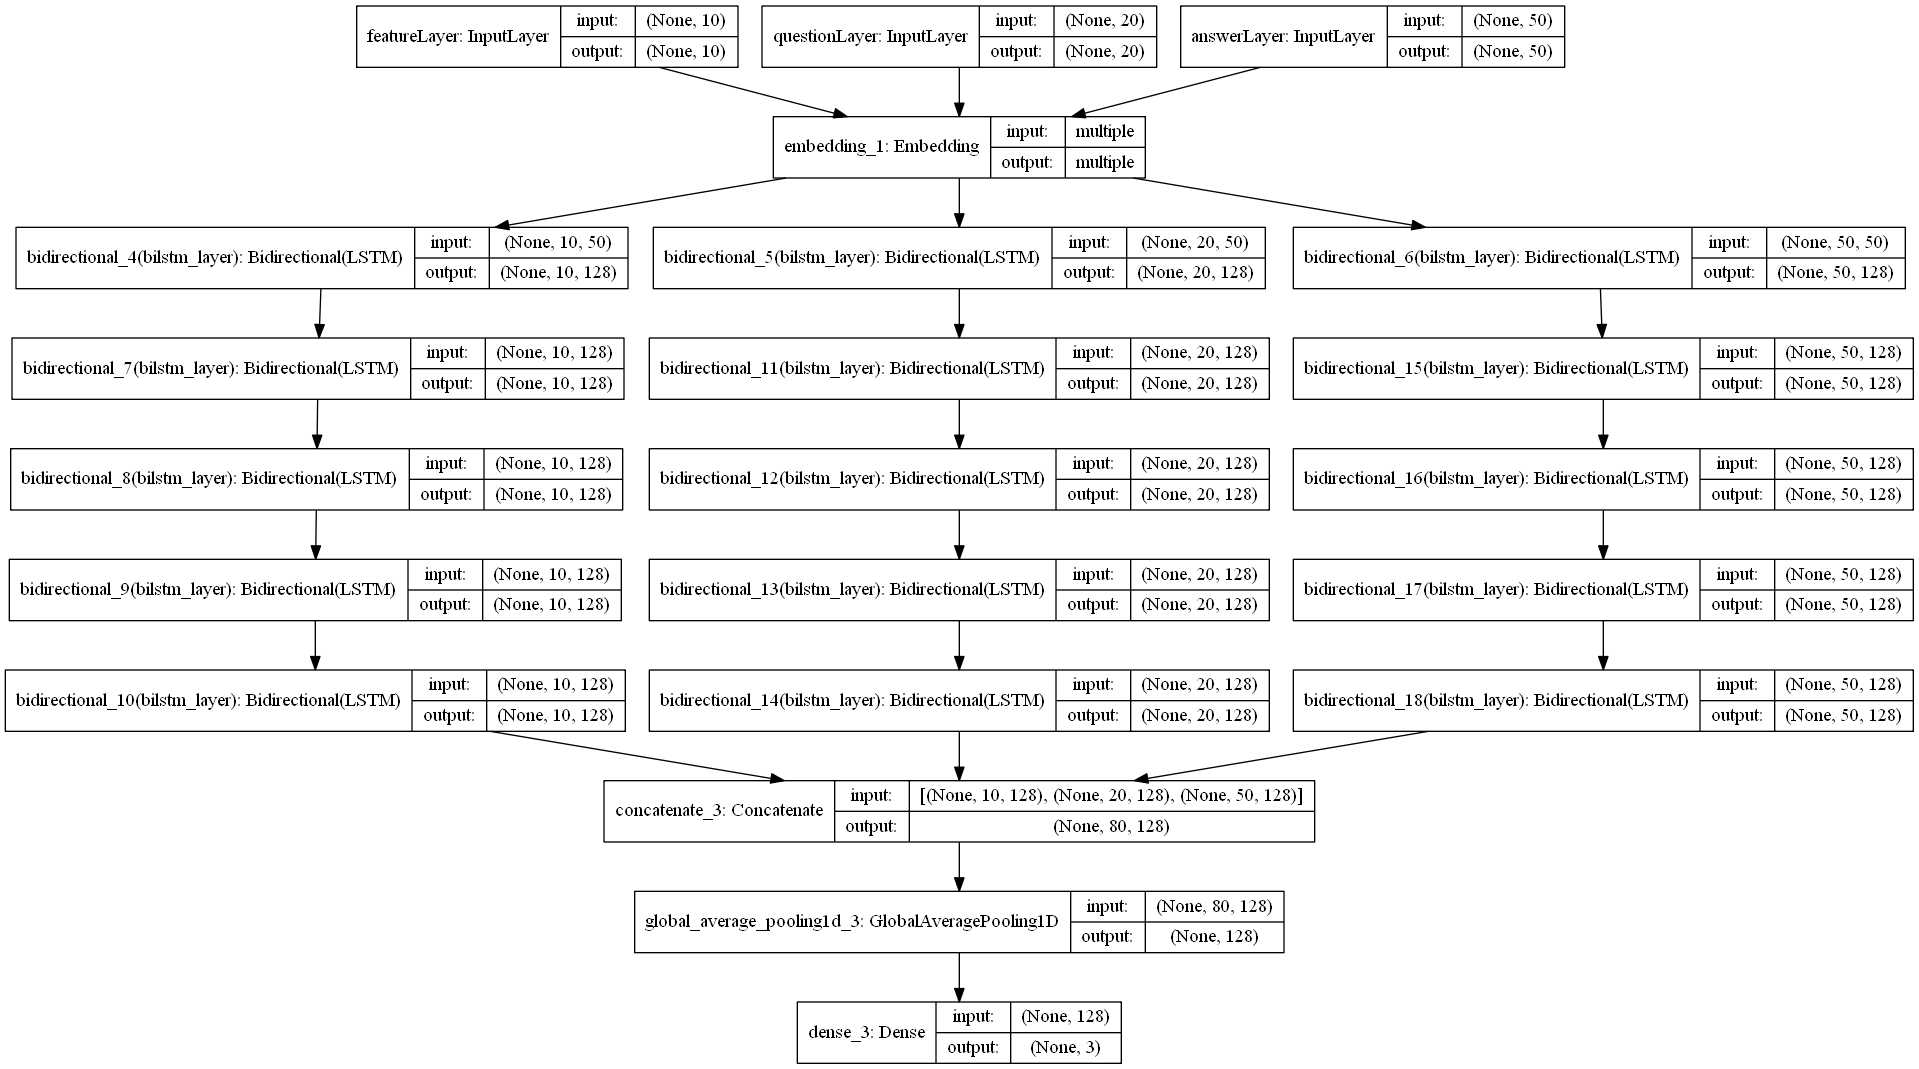

In [31]:
STACKED_EMBEDDINGS = [stacked_n1, stacked_n2, stacked_n3]

model_stacked_bilstm = classification_model(STACKED_EMBEDDINGS, INPUT_SEQUENCES)
plot_model(model_stacked_bilstm, to_file = 'model_stacked_bilstm.png', show_shapes=True, show_layer_names=True)

In [32]:
history_stacked_bilstm = training_model(model_stacked_bilstm, 'model-stacked-bilstm', TRAIN_FIT, VAL_FIT) 

Train on 19990 samples, validate on 5000 samples
Epoch 1/80
19990/19990 [==============================] - 329s 16ms/step - loss: 0.5891 - acc: 0.8150 - val_loss: 0.6175 - val_acc: 0.8122

Epoch 00001: acc improved from -inf to 0.81501, saving model to model-stacked-bilstm_checkpoint.h5
Epoch 2/80
19990/19990 [==============================] - 319s 16ms/step - loss: 0.5582 - acc: 0.8187 - val_loss: 0.6032 - val_acc: 0.8122

Epoch 00002: acc improved from 0.81501 to 0.81871, saving model to model-stacked-bilstm_checkpoint.h5
Epoch 3/80
19990/19990 [==============================] - 319s 16ms/step - loss: 0.5440 - acc: 0.8201 - val_loss: 0.5977 - val_acc: 0.8122

Epoch 00003: acc improved from 0.81871 to 0.82006, saving model to model-stacked-bilstm_checkpoint.h5
Epoch 4/80
19990/19990 [==============================] - 319s 16ms/step - loss: 0.5372 - acc: 0.8188 - val_loss: 0.6079 - val_acc: 0.8122

Epoch 00004: acc did not improve from 0.82006
Epoch 5/80
19990/19990 [==================

19990/19990 [==============================] - 317s 16ms/step - loss: 0.4540 - acc: 0.8413 - val_loss: 0.6453 - val_acc: 0.8066

Epoch 00038: acc improved from 0.84067 to 0.84127, saving model to model-stacked-bilstm_checkpoint.h5
Epoch 39/80
19990/19990 [==============================] - 317s 16ms/step - loss: 0.4515 - acc: 0.8407 - val_loss: 0.6030 - val_acc: 0.8048

Epoch 00039: acc did not improve from 0.84127
Epoch 40/80
19990/19990 [==============================] - 317s 16ms/step - loss: 0.4512 - acc: 0.8420 - val_loss: 0.6002 - val_acc: 0.8054

Epoch 00040: acc improved from 0.84127 to 0.84202, saving model to model-stacked-bilstm_checkpoint.h5
Epoch 41/80
19990/19990 [==============================] - 316s 16ms/step - loss: 0.4495 - acc: 0.8412 - val_loss: 0.6296 - val_acc: 0.8040

Epoch 00041: acc did not improve from 0.84202
Epoch 42/80
19990/19990 [==============================] - 317s 16ms/step - loss: 0.4467 - acc: 0.8438 - val_loss: 0.6465 - val_acc: 0.8002

Epoch 00042

In [33]:
save_models(model_stacked_bilstm, 'model_stacked_bilstm')


THIS MODEL HAS BEEN SAVED TO DIRECTORY:  C:\Users\91901\Code Here\CQA\1 go-to files functions


training of model


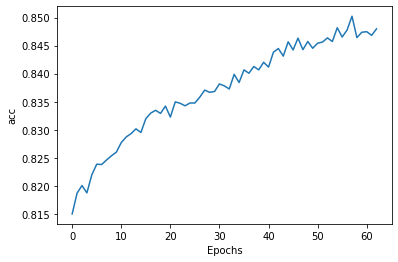

training of model


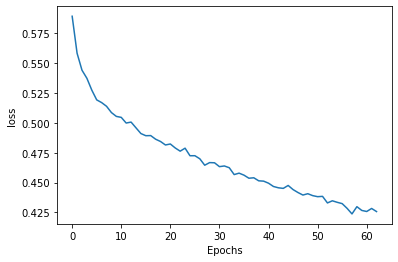

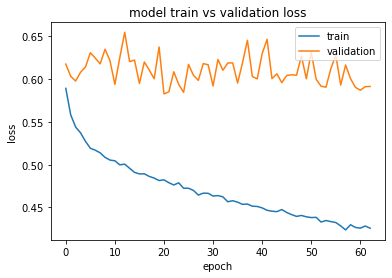

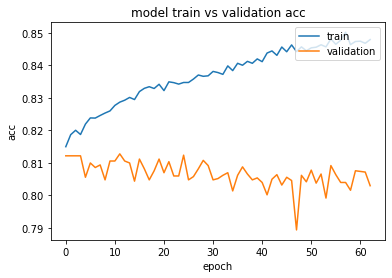

In [34]:
plot_graphs(history_stacked_bilstm, 'acc')
plot_graphs(history_stacked_bilstm, 'loss')
plot_both_graphs(history_stacked_bilstm)

In [35]:
model_predictions_stacked_bilstm, predicted_class_names_stacked_bilstm = evaluate_model(model_stacked_bilstm, TEST_FIT)

Evaluated on metrics  ['loss', 'acc']
7000/7000 [==============================] - 16s 2ms/step
Test Loss : 0.5826773917845317 Test Accuracy:  0.817714273929596

predictions shape is:  (7000, 3)


 Predictions into Class Labels: [0 0 0 ... 0 0 0]


 METRICS CLASSIFICATION REPORT IS:
               precision    recall  f1-score   support

           0       0.85      0.95      0.90      5943
           1       0.04      0.00      0.01       403
           2       0.18      0.09      0.12       654

    accuracy                           0.82      7000
   macro avg       0.36      0.35      0.34      7000
weighted avg       0.75      0.82      0.78      7000



In [36]:
result_stacked_bilstm = result_store(predicted_class_names_stacked_bilstm)

print("no of true labels:\n", result_stacked_bilstm.true_label.value_counts())
print("no of predicted labels:\n", result_stacked_bilstm.predicted_label.value_counts())

result_stacked_bilstm.head()

no of true labels:
 0    5943
2     654
1     403
Name: true_label, dtype: int64
no of predicted labels:
 0    6623
2     330
1      47
Name: predicted_label, dtype: int64


,feature,text_1,text_2,true_label,predicted_label
0,"""IT Jobs in Qatar","""""how hard is it for you to get a decent payin...",Are you Qatari? That may be the answer.,1,0
1,"""IT Jobs in Qatar","""""how hard is it for you to get a decent payin...",No I am not qatari; but I can speak Arabic; It...,0,0
2,"""IT Jobs in Qatar","""""how hard is it for you to get a decent payin...",Not easy..... unless you have a father's rp or...,2,0
3,"""IT Jobs in Qatar","""""how hard is it for you to get a decent payin...",Wasta my child...thats all it takes. Having Am...,2,0
4,"""IT Jobs in Qatar","""""how hard is it for you to get a decent payin...",also as tahsinmim said..helps sometimes to han...,0,0


In [41]:
results_path = os.getcwd() 
result_stacked_bilstm.to_csv(os.path.join(results_path,'FQA-STACKED-BILSTM-CLASSIFIED.csv'), index_label = False, index = False)

# for Q, A body text only

In [21]:
#%%
# MODEL FOR (Q,A)'s BODY-TEXT ONLY 

#CUSTOM COLUMNS
INPUT_SEQUENCES = [sequence_input_ques, sequence_input_ans]
INPUT_EMBEDDINGS = [n2, n3]
TRAIN_FIT = [t2_train, t3_train]
TEST_FIT = [t2_test, t3_test]
VAL_FIT = [t2_val, t3_val]

nn_units = 128
dropout_inputs = 0.2
recurrent_dropout_inputs = 0.15
batchsize = 64
epochs_count = 100

def result_storeQA(predicted_class_names):
    
    df = pd.DataFrame(columns = ['text_1', 'text_2', 'true_label'])
    df['text_1'] = x_test
    df['text_2'] = xx_test
    df['true_label'] = y_test
    df['predicted_label'] = predicted_class_names

    return df

In [66]:
#FIRST MODEL

# n2 = bilstm_embeddings(embedded_ques_sequences)
# n3 = bilstm_embeddings(embedded_ans_sequences)

# print(n1)
# print(n2)
# print(n3)

# model_bilstm = classification_model(INPUT_EMBEDDINGS, INPUT_SEQUENCES)
# plot_model(model_bilstm, to_file = 'model_QA_bilstm.png', show_shapes=True, show_layer_names=True)

# history_bilstm = training_model(model_bilstm, 'model-QA-bilstm', TRAIN_FIT, VAL_FIT) 
# save_models(model_bilstm, 'model-QA-bilstm')

# plot_graphs(history_bilstm, 'acc')
# plot_graphs(history_bilstm, 'loss')

# plot_both_graphs(history_bilstm)

# model_predictions_bilstm, predicted_class_names_bilstm = evaluate_model(model_bilstm, TEST_FIT)

# result_bilstm = result_storeQA(predicted_class_names_bilstm)

# print("no of true labels:\n", result_bilstm.true_label.value_counts())
# print("no of predicted labels:\n", result_bilstm.predicted_label.value_counts())

# result_bilstm.head()

# results_path = os.getcwd()
# result_bilstm.to_csv(os.path.join(results_path,'QA-BILSTM-CLASSIFIED.csv'), index_label = False, index = False)

Tensor("bidirectional_9/concat:0", shape=(None, 20, 256), dtype=float32)
Tensor("bidirectional_13/concat:0", shape=(None, 50, 256), dtype=float32)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
questionLayer (InputLayer)      (None, 20)           0                                            
__________________________________________________________________________________________________
answerLayer (InputLayer)        (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             20000050    questionLayer[0][0]              
                                                                 answerLayer[0][0]                
____________________________________________

19990/19990 [==============================] - 139s 7ms/step - loss: 0.3319 - acc: 0.8785 - val_loss: 0.7067 - val_acc: 0.7666

Epoch 00055: acc improved from 0.87544 to 0.87854, saving model to modelQA-stacked-bilstm_checkpoint.h5
Epoch 56/100
19990/19990 [==============================] - 140s 7ms/step - loss: 0.3265 - acc: 0.8775 - val_loss: 0.7175 - val_acc: 0.7658

Epoch 00056: acc did not improve from 0.87854
Epoch 57/100
19990/19990 [==============================] - 138s 7ms/step - loss: 0.3210 - acc: 0.8832 - val_loss: 0.7406 - val_acc: 0.7910

Epoch 00057: acc improved from 0.87854 to 0.88324, saving model to modelQA-stacked-bilstm_checkpoint.h5
Epoch 58/100
19990/19990 [==============================] - 139s 7ms/step - loss: 0.3196 - acc: 0.8815 - val_loss: 0.7889 - val_acc: 0.7956

Epoch 00058: acc did not improve from 0.88324
Epoch 59/100
19990/19990 [==============================] - 140s 7ms/step - loss: 0.3155 - acc: 0.8831 - val_loss: 0.7288 - val_acc: 0.7634

Epoch 00

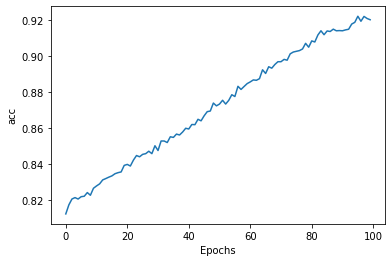

training of model


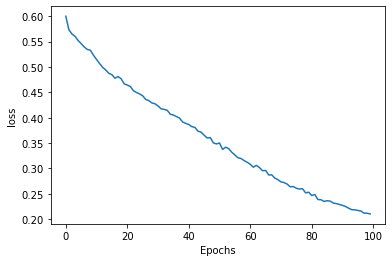

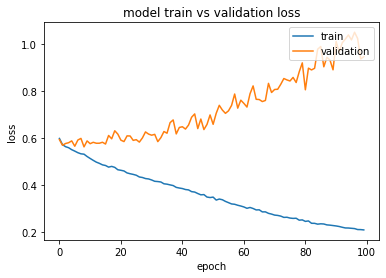

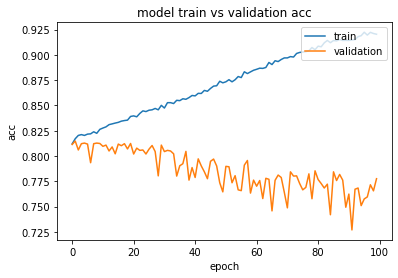

Evaluated on metrics  ['loss', 'acc']
7000/7000 [==============================] - 9s 1ms/step
Test Loss : 0.9125742094346455 Test Accuracy:  0.7914285659790039

predictions shape is:  (7000, 3)


 Predictions into Class Labels: [0 0 0 ... 0 0 0]


 METRICS CLASSIFICATION REPORT IS:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89      5943
           1       0.09      0.09      0.09       403
           2       0.28      0.15      0.20       654

    accuracy                           0.79      7000
   macro avg       0.41      0.38      0.39      7000
weighted avg       0.77      0.79      0.78      7000

no of true labels:
 0    5943
2     654
1     403
Name: true_label, dtype: int64
no of predicted labels:
 0    6238
1     401
2     361
Name: predicted_label, dtype: int64


In [22]:
# SECOND Stacked Model

# call for embeddings according to new parameters

n2 = bilstm_embeddings(embedded_ques_sequences)
n3 = bilstm_embeddings(embedded_ans_sequences)

# print(n1)
# print(n2)
# print(n3)


stacked_n2 = stacked_bilstm_embeddings(n2)
stacked_n3 = stacked_bilstm_embeddings(n3)

print(stacked_n2)
print(stacked_n3)

STACKED_EMBEDDINGS = [stacked_n2, stacked_n3]

model_stacked_bilstm = classification_model(STACKED_EMBEDDINGS, INPUT_SEQUENCES)
plot_model(model_stacked_bilstm, to_file = 'modelQA_stacked_bilstm.png', show_shapes=True, show_layer_names=True)

history_stacked_bilstm = training_model(model_stacked_bilstm, 'modelQA-stacked-bilstm', TRAIN_FIT, VAL_FIT) 

save_models(model_stacked_bilstm, 'modelQA_stacked_bilstm')

plot_graphs(history_stacked_bilstm, 'acc')
plot_graphs(history_stacked_bilstm, 'loss')
plot_both_graphs(history_stacked_bilstm)

model_predictions_stacked_bilstm, predicted_class_names_stacked_bilstm = evaluate_model(model_stacked_bilstm, TEST_FIT)

result_stacked_bilstm = result_storeQA(predicted_class_names_stacked_bilstm)

print("no of true labels:\n", result_stacked_bilstm.true_label.value_counts())
print("no of predicted labels:\n", result_stacked_bilstm.predicted_label.value_counts())

result_stacked_bilstm.head()

results_path = os.getcwd() 
result_stacked_bilstm.to_csv(os.path.join(results_path,'QA-STACKED-BILSTM-CLASSIFIED.csv'), index_label = False, index = False)
